In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import os, sys
import time

import copy
import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool

import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############

# My functions:
sys.path.insert(0, '../')
import vqe_functions as vqe
import qcnn_functions as qcnn

In [2]:
N = 8

J = 1

In [3]:
device_jax = qml.device("default.qubit.jax", wires = N, shots = None)
device_mix = qml.device("default.mixed", wires = N, shots = None) 
device_def = qml.device("default.qubit", wires = N, shots = None)

# VQE

In [153]:

step_size = 0.005
l_steps = 100

In [19]:
def qml_build_H(N, lam, J, ring = False):
    '''
    Set up Hamiltonian: 
            H = lam*Σsigma^i_z - J*Σsigma^i_x*sigma^{i+1}_ 
    '''
    # Interaction of spins with magnetic field
    H = + lam * qml.PauliZ(0)
    for i in range(1,N):
        H = H + lam * qml.PauliZ(i)
        
    # Interaction between spins:
    for i in range(0,N-1):
        H = H + J*(-1)*( qml.PauliX(i) @ qml.PauliX(i+1) )
    
    # Ring
    if ring:
        # Create interaction between first and last qubit
        H = H + J*(-1)*( qml.PauliX(N-1) @ qml.PauliX(0) )
    
    return H

In [149]:
def train_jax(step_size, n_epochs, N, J, l_steps, device, vqe_circuit_fun, circuit = False, plots = False, parameter_info = True):
    
    lams = np.linspace(0, 2*J, l_steps)
    
    if parameter_info:
        print('+--- PARAMETERS ---+')
        print('step_size      = {0} (Step size of the optimizer)'.format(step_size))
        print('n_epochs       = {0} (# epochs for the other GSs)'.format(n_epochs))
        print('N              = {0} (Number of spins of the system)'.format(N))

    
    @qml.qnode(device, interface="jax")
    def vqe_cost_fn(vqe_params, N, H, p_noise = 0, p_noise_ent = 0):
        vqe_circuit_fun(N, vqe_params, p_noise, p_noise_ent)

        # return <psi|H|psi>
        return qml.expval(H)

    @qml.qnode(device, interface="jax")
    def vqe_state(vqe_params, N):
        vqe_circuit_fun(N, vqe_params)
        
        return qml.state()
    
    v_vqe_state = jax.vmap(lambda v:  vqe_state(v, N), in_axes=(0))
    
    # circuit functions returns the number of parameters needed for the circuit itself
    n_params = vqe_circuit_fun(N, [0]*1000)
    
    # Prepare initial parameters randomly for each datapoint/state
    param = np.random.rand(n_params)
    params0 = []
    for _ in lams:
        params0.append(param)
    
    params = jnp.array(params0)
    
    if circuit:
        # Display the circuit
        print('+--- CIRCUIT ---+')
        drawer = qml.draw(vqe_cost_fn)
        print(drawer(np.arange(n_params), N, H = qml_build_H(N, 0 ,0)))
    
    # For each lamda create optimizer and H
    Hs    = []
    Hsmat = []
    opts  = []
    energy_err  = [0]*(len(lams))
    true_e = []
    
    for i, lam in enumerate(lams):
        Hs.append(qml_build_H(N, float(lam), float(J) ))
        true_e.append(np.min(qml.eigvals(Hs[i])) )
        Hsmat.append(qml.matrix(Hs[-1]) )
    
    true_e = jnp.array(true_e)
    Hsmat = jnp.array(Hsmat)
    
    def compute_E(state, Hmat):
        return jnp.conj(state) @ Hmat @ state
    
    v_compute_E = jax.vmap(compute_E, in_axes=(0,0) )
    
    def update(params):
        pred_states = v_vqe_state(params)
        vqe_e = v_compute_E(pred_states, Hsmat)

        return jnp.mean(jnp.square(jnp.real(vqe_e)-true_e))
    
    def compute_vqe(params):
        pred_states = v_vqe_state(params)
        vqe_e = v_compute_E(pred_states, Hsmat)

        return vqe_e
    
    progress = tqdm.tqdm(range(n_epochs), position=0, leave=True)
    
    jd_update = jax.jit(jax.grad(update))
    j_compute_vqe = jax.jit(compute_vqe)
    
    for it in progress:
        params -= step_size*jd_update(params)
        
    vqe_e = j_compute_vqe(params)
    
    if plots:
        fig, ax = plt.subplots(4, 1, figsize=(12,18.6))
                          
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()
        
        '''ax[1].plot(range(n_epochs), MSE, '.', color='orange', ms = 7 )
        ax[1].plot(range(n_epochs), MSE, color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        
        rho_dist = []
        for rho in range(l_steps - 1):
            rho_dist.append( np.real( np.mean( np.square(density_matrices(params[rho], N, 0) - density_matrices(params[rho+1], N, 0)) ) ) )
            
        ax[3].set_title('Mean square distance between consecutives density matrices')
        ax[3].plot(np.linspace(0,2*J, num=l_steps-1), rho_dist, '-o')
        ax[3].grid(True)
        ax[3].axvline(x=J, color='gray', linestyle='--')
        ax[3].set_xlabel(r'$\lambda$')'''
        
        plt.tight_layout()
        
    ys = []
    for l in lams:
        ys.append(0) if l <= J else ys.append(1)
        
    return vqe_e, params, ys   


+--- PARAMETERS ---+
step_size      = 0.005 (Step size of the optimizer)
n_epochs       = 50000 (# epochs for the other GSs)
N              = 8 (Number of spins of the system)


100%|████████████████████████████████████| 50000/50000 [02:45<00:00, 301.83it/s]


NameError: name 'MSE' is not defined

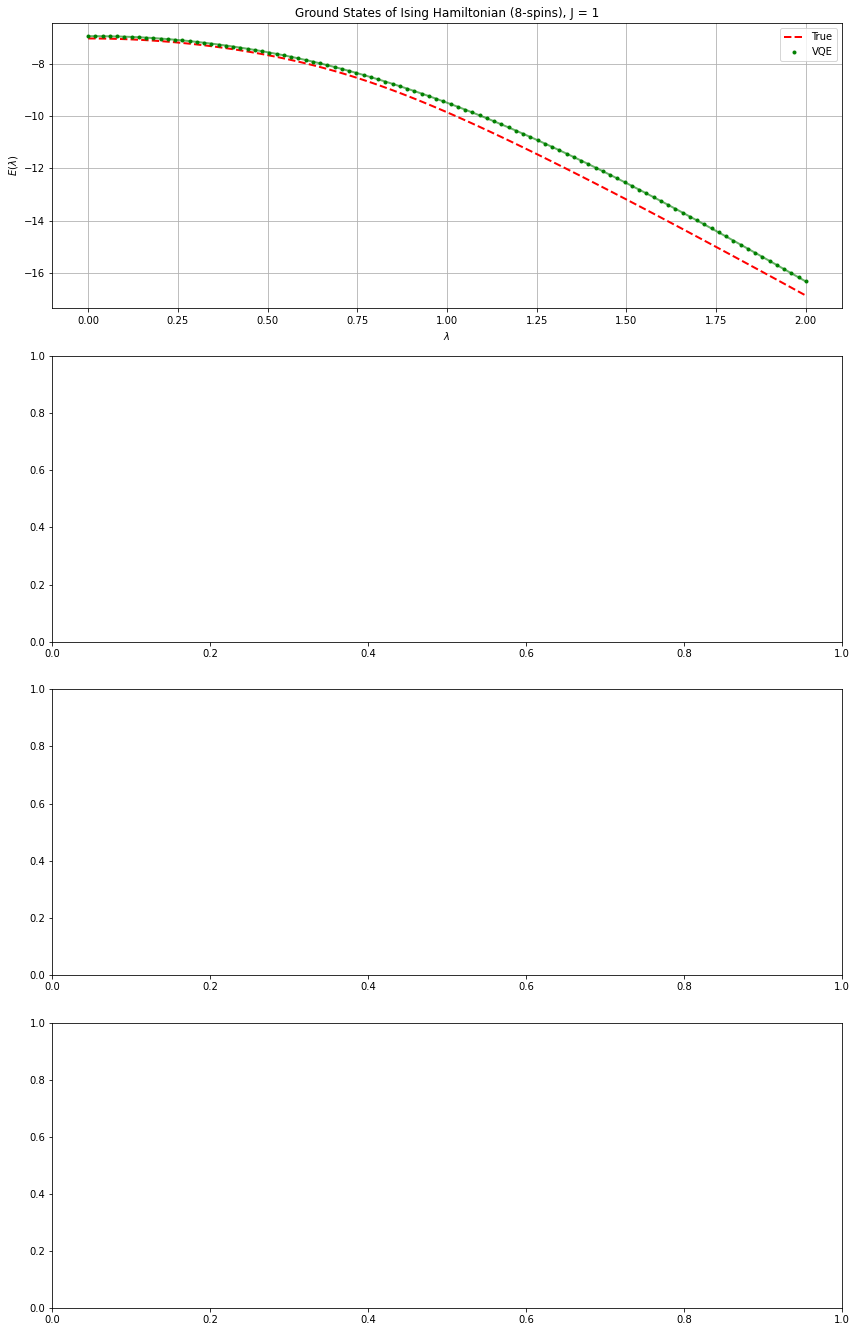

In [154]:
a = train_jax(step_size, 50000, N, J, l_steps, device_jax, vqe.vqe_circuit, plots = True)

In [130]:
a

DeviceArray([-1.0476055, -1.0580204, -1.0684352, -1.0788503, -1.0892651,
             -1.0996801, -1.110095 , -1.1205099, -1.1309249, -1.1413399,
             -1.1517546, -1.1621696, -1.1725845, -1.1829995, -1.1934144,
             -1.2038294, -1.2142442, -1.2246591, -1.235074 , -1.2454889,
             -1.255904 , -1.2663188, -1.2767338, -1.2871487, -1.2975636,
             -1.3079786, -1.3183935, -1.3288084, -1.3392231, -1.3496381,
             -1.3600531, -1.3704681, -1.380883 , -1.391298 , -1.4017127,
             -1.4121277, -1.4225428, -1.4329575, -1.4433726, -1.4537876,
             -1.4642024, -1.4746172, -1.4850323, -1.495447 , -1.5058622,
             -1.516277 , -1.5266919, -1.5371068, -1.5475218, -1.5579368,
             -1.5683516, -1.5787667, -1.5891814, -1.5995965, -1.6100113,
             -1.6204262, -1.6308411, -1.6412561, -1.651671 , -1.662086 ,
             -1.672501 , -1.6829158, -1.6933306, -1.7037458, -1.7141606,
             -1.7245753, -1.7349906, -1.7454053, -1

In [123]:
np.conj(a[0]) @ b[0] @ a[0]

DeviceArray(-1.3149171-1.8626451e-08j, dtype=complex64)

In [76]:
print(np.shape(a), np.shape(b))

(100, 256) (100, 256, 256)


# Default.mixed (multiprocessed) 
vqe_e, errs, thetas2, ys = vqe.train(0.02, epochs, N, J, l_steps, device_def, vqe.vqe_circuit, optimizer = 'adam',
                                    circuit = True, plots = True, prepare_states = False, preplots = True, pretrained = thetas,
                                    prep_step_size = 0.25, first_prep_epoch = first_prep_epoch, prep_epochs = prep_epochs, parameter_info = True)

+--- PARAMETERS ---+
step_size      = 0.025 (Step size of the optimizer)
prep_step_size = 0.005 (Step size in the preparing state phase)
n_epochs       = 1 (# epochs for the other GSs)
prep_epochs    = 25 (# epochs in the preparing state phase)
N              = 8 (Number of spins of the system)
cutoff_value   = 0.01 (Cuttoff Value in relative error to stop training)

+--- CIRCUIT ---+
0: ──RY(0.00)──RX(8.00)───||─╭C────────────────────||──RY(16.00)──RX(24.00)──||─╭C──────────────────
1: ──RY(1.00)──RX(9.00)───||─╰X─╭C─────────────────||──RY(17.00)──RX(25.00)──||─╰X─╭C───────────────
2: ──RY(2.00)──RX(10.00)──||────╰X─╭C──────────────||──RY(18.00)──RX(26.00)──||────╰X─╭C────────────
3: ──RY(3.00)──RX(11.00)──||───────╰X─╭C───────────||──RY(19.00)──RX(27.00)──||───────╰X─╭C─────────
4: ──RY(4.00)──RX(12.00)──||──────────╰X─╭C────────||──RY(20.00)──RX(28.00)──||──────────╰X─╭C──────
5: ──RY(5.00)──RX(13.00)──||─────────────╰X─╭C─────||──RY(21.00)──RX(29.00)──||─────────────╰X─╭C───
6: ──R

100%|█████████████████████████████████████████| 100/100 [02:54<00:00,  1.75s/it]


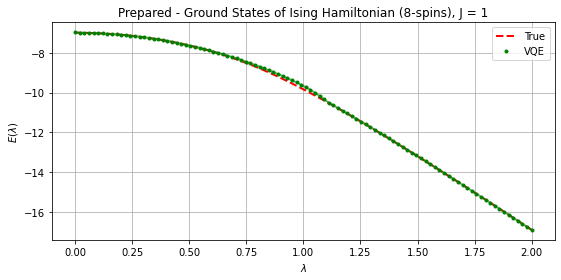

Cost: 0.0030581226674391416 | Active states: 13: 100%|█| 1/1 [00:01<00:00,  1.33


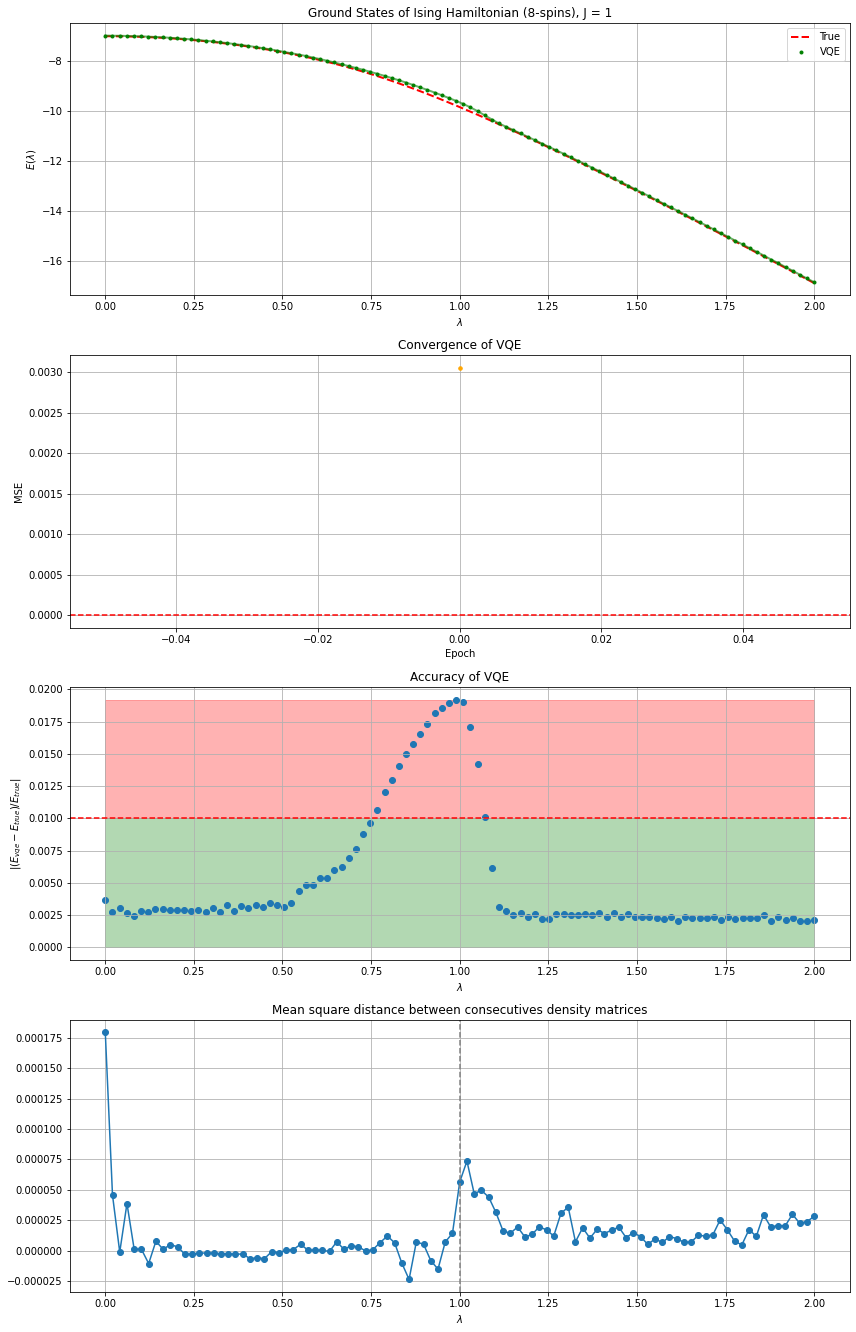

In [9]:
# Default.mixed (multiprocessed) 
vqe_e, errs, thetas, ys = vqe.train(0.025, 1, N, J, l_steps, device_def, vqe.vqe_circuit, optimizer = 'adam',
                                    circuit = True, plots = True, prepare_states = True, preplots = True,
                                    prep_step_size = 0.005, first_prep_epoch = first_prep_epoch, prep_epochs = prep_epochs, parameter_info = True)


In [12]:
vqe_data_x = thetas 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, '../vqe_states_job/0noiseN'+str(N)+'.job')

['../vqe_states_job/0noiseN8.job']

In [4]:
# Load data and separate in training and test set
data = joblib.load('../vqe_states_job/0noiseN'+str(N)+'.job')

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))

X_train, Y_train = [], []
X_test, Y_test   = [], []
X, Y             = [], []
for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
        X.append(data[i][0])
        Y.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        X.append(data[i][0])
        Y.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('CLEAN DATA:')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data)))
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))

CLEAN DATA:
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20


In [5]:
qcnn_circuit = qcnn.qcnn_circuit
vqe_circuit = vqe.vqe_circuit

In [6]:
vqe_circuit, qcnn_circuit = vqe.vqe_circuit, qcnn.qcnn_circuit

+-- PARAMETERS ---+
a factor   = 0.05 ('a' coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 8 (Number of spins of the system)


Cost: 0.31114837527275085: 100%|██████████████| 500/500 [00:14<00:00, 33.55it/s]


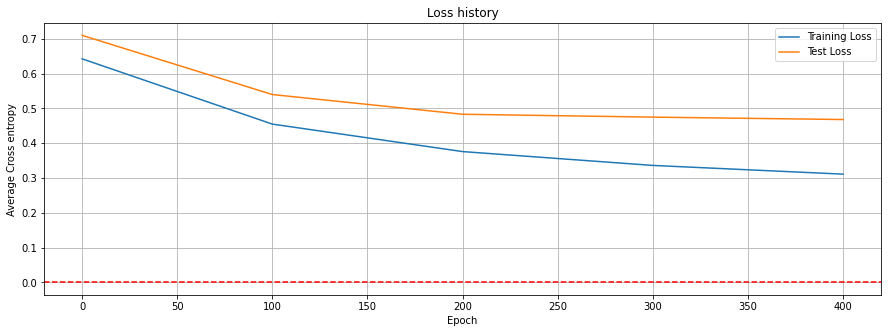

In [7]:
loss, params = qcnn.jax_train(500, 0.05, N, device_jax, vqe_circuit, qcnn_circuit, X_train, Y_train, X_test, Y_test, plot = True, info = True)

In [8]:
X = jnp.array(X)
Y = jnp.array(Y)

(80,)


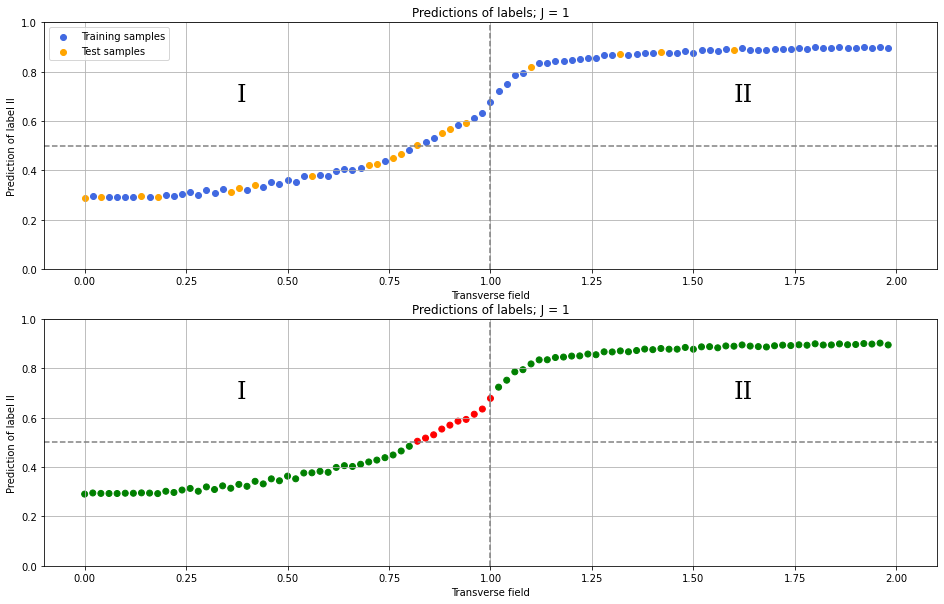

In [9]:
qcnn.jax_plot_results_classification(X, Y, train_index, params, N, device_jax, vqe_circuit, qcnn_circuit)
